

<h1 align="center"> Unsupervised learning (II): similarity </h1>

* * *


##### Goals:
- Understand the difference between distance and similarity
- Apply this concept to face recognition

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
root = "/content/drive/MyDrive/Data/facerecognition"
sys.path.append(root)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Part 1: Introduction
To explain the notion of similarity, consider the following example. We want to aggregate documents based on their topics. For the sake of simplicity, we take documents made of only a few sentences. The following cell reads the documents.

In [ ]:
with open(f"{root}/text/nfts.txt", "r") as docsfile:
    documents = docsfile.read().split('\n---\n')
print(f"Number of documents: {len(documents)}")
print(f"First document:\n\n {documents[0][:500]}")

Number of documents: 5
First document:

 The Manchester United and France midfielder, though, is far from alone as a footballer who has put his name to NFT schemes.

To their advocates, they are an exciting digital version of collectibles such as trading cards. Critics, though, say they are a vehicle for financial speculation, while lack of regulation means investors have little recourse if they lose huge sums of money buying and selling NFTs. And the figures are generally only going one way at the moment.

John Terry’s disastrous Ape 


### Question 1
The top 2 common themes of these articles are NFTs and football. We want to classify them based on the extent to which these themes are present. To do so, write a function that takes a document in argument (a string) and returns a vectors containing the number of times the words "nft", "nfts", "football", "footballer" are present, in that order.

For example, `text_to_vec("a footballer bought two NFTs: 1 digital art NFT and 1 music NFT")` should return: `[2, 1, 0, 1]`.

*Hint: Check the documentation of these string and list methods: (`string.lower` `string.split` `list.count`)*

In [ ]:
def text_to_vec(documents, dictionary=["nft", "nfts", "football", "footballer", "footballers"]):
    lowered_text = str(documents).lower()
    text = lowered_text.split()
    result = [text.count(word) for word in dictionary]
    return result

print(text_to_vec(documents))

[41, 37, 10, 2, 3]


### Question 2
To make things simple, modify the function `text_to_vec` so that it aggregates the counts for ["nft, "nfts"] and ["football", "footballer", "footballers"]. The same example above should then return: `[3, 2]`. Then transform the list of documents to a list of vectors.

In [ ]:
def text_to_vec(documents, dictionary=[["nft", "nfts"],["football", "footballer", "footballers"]]):
    text = str(documents).lower().split()
    nftCount, footballCount = 0, 0
    for word in text:
      if word in dictionary[0]:
        nftCount += 1
      elif word in dictionary[1]:
        footballCount += 1
    result = [nftCount, footballCount]
    return result

print(text_to_vec("a footballer bought two NFTs: 1 digital art NFT and 1 music NFT")) # doesnt count the colon attached and only one footballer mentioned

vectors = [text_to_vec(document) for document in documents]
print(vectors)


[2, 1]
[[8, 3], [22, 0], [3, 0], [23, 8], [23, 5]]


### Question 3
Print the vector of each documents. Intuitively, based only on these counts what documents do you consider similar / dissimilar ? Use the function below to visualize the vectors. Is this visualization in agreement with your intuition ?

Based on these counts, I believe documents 1, 3, and 4 to be similar as they have the same x vals (or nft/nfts count).

Document 0 [8, 3]
Document 1 [22, 0]
Document 2 [3, 0]
Document 3 [23, 8]
Document 4 [23, 5]


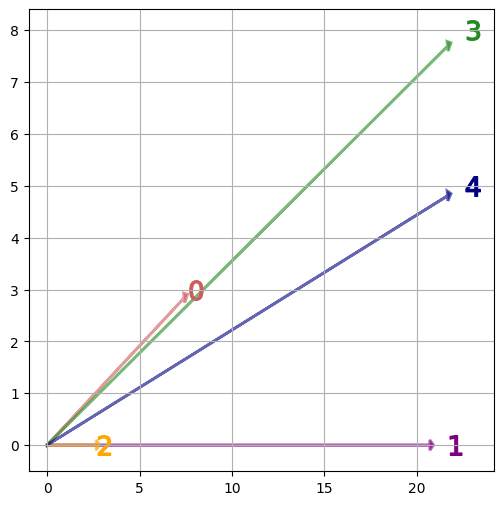

In [ ]:
def plot_vectors(vectors):

    colors = ["indianred", "purple", "orange", "forestgreen", "navy"]
    plt.figure(figsize=(6, 6))
    for ii, vec in enumerate(vectors):
        plt.arrow(0,0,vec[0] * 0.95, vec[1] * 0.97,
        shape='full', color=colors[ii], length_includes_head=True,
        zorder=0, head_length=0.2, head_width=0.2, alpha=0.6, lw=2)
        plt.scatter(vec[0], vec[1], marker=rf"${ii}$", color=colors[ii], s=200)
    plt.grid()
    plt.xlim([-1, None])
    plt.show()

i = 0
while i < len(documents):
  print("Document " + str(i), text_to_vec(documents[i]))
  i+=1
plot_vectors(vectors)


The visualization is pretty much in agreement with my intuition as they all extend the same length, but the y axis does make them seem farther in height relative to the others. 3 & 4 are definitely the most similar.

### Question 4
Normalize the vectors by their norm so that their Euclidean norm $\|.\|_2$ is equal to 1. Visualize the new vectors. What to you observe ?

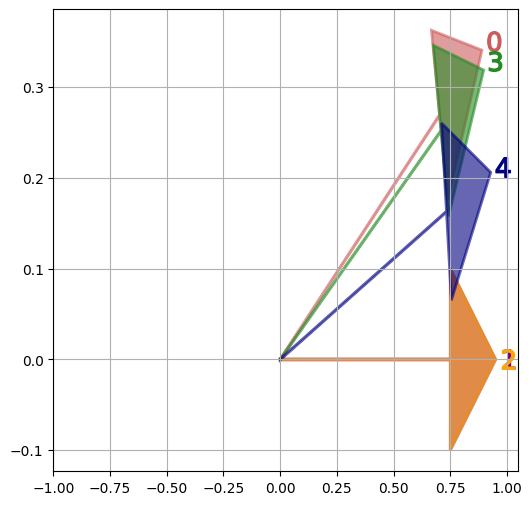

In [ ]:
def normalize(vector):
    norm = np.linalg.norm(vector)
    return vector/norm

norm_vectors = [normalize(vector) for vector in vectors]
plot_vectors(norm_vectors)

I observe that they all do not extend past a length of one and that documents 0 & 3 are very similar to each other along with 1 & 2 being seemingly exact.

### Question 5
Compute the Euclidean distance between two unit-norm vectors $x$ and $y$. Can you deduce from it a notion of similarity between two vectors $x$ and $y$ ?

In [ ]:
# x,y = norm_vectors[0], norm_vectors[1]
i = 0
while i < len(documents) - 1:
  euclid_distance = np.linalg.norm(norm_vectors[i]-norm_vectors[i+1])
  print(euclid_distance)
  i +=1


0.35684961098747325
0.0
0.333176239530495
0.1206029431337046


I can deduce that vectors $x$ and $y$ are more similar the closer their distance is to zero and more dissimilar if their distance approaches one. It can be seen that unit norm vectors 1 & 2 are identical as their distance is zero.

# Part 2: Similarity score for face recognition

The following cell reads the facial images dataset of celebrities and images of non-celebrities, here referred to as "impostors".

In [ ]:
import cv2
import torch
import glob

labels = []
imgs = []
celebs = ["thorne", "mac", "kendrick", "jolie", "hathaway", "arnold", "benedict", "impostors"]
genders_list = [1, 0, 1, 1, 1, 0, 0, None]
genders = []


for label, name in enumerate(celebs):
    imgpath = f"{root}/imgs/{name}/"
    gender = genders_list[label]
    for ii, filename in enumerate(glob.glob(imgpath + "*.jpg")):
        img = cv2.imread(filename)
        if img is None:
            print(filename)
            break
        img = cv2.resize(img, (112, 112))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.transpose(img, (2, 0, 1))
        img = torch.from_numpy(img).float()
        img.div_(255).sub_(0.5).div_(0.5)
        imgs.append(img)
        labels.append(label)
        if gender is not None:
            genders.append(gender)

with open(f"{root}/imgs/gender.txt", "r") as genderfile:
    gender_imp = genderfile.read().split(',\n')
gender_imp = np.array(gender_imp).astype(int)

genders.extend(gender_imp)
imgs = torch.stack(imgs)
labels = np.array(labels)

labels[labels < len(celebs) - 1] = 0
labels[labels == len(celebs) - 1] = 1
genders = np.array(genders)
labels = torch.tensor(labels)

print(imgs.shape, labels.shape, genders.shape)
print("pct of imposters = ", 100 * labels.float().mean().item())
print("pct of males = ", 100 * (1- genders.mean()))

/content/drive/MyDrive/Data/facerecognition/imgs/mac/12 17.32.53.jpg
torch.Size([315, 3, 112, 112]) torch.Size([315]) (234,)
pct of imposters =  35.23809611797333
pct of males =  31.62393162393162


An embedding is a neural network transforming a sample (image, text, data ..) to multi-dimensional space -- generally with a lower dimension than the input space. Such that this new representation is more "meaningful". For example, a good text embedding would provide a representation where words having a close meaning would be geometrically closer. Here we use an embedding for facial recognition which is already pre-trained i.e we only read the weights which are already optimized.

In general, the goal is to learn a neural net such that by computing the similarity score, it is very easy to detect impostors from genuine samples.

In [ ]:
import torch
from backbones import get_model
modelpath = f"{root}/models/backbone-r100.pth"
network = "r100"
output_dir = "outputs/"
batch_size = 128
device = "cpu"
# load backbone
model = get_model(network, fp16=False)
model.load_state_dict(torch.load(modelpath, map_location='cpu'))
model.eval()

IResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prelu): PReLU(num_parameters=64)
  (layer1): Sequential(
    (0): IBasicBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=64)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): IBas

### Question 6
Use the loaded pre-trained model to compute the embedding of all the images. The resulting object should be one matrix containing the embeddings of all images. Use GPUs for speed-up.

In [ ]:
device = torch.device("cuda") #gpu speed up
model.to(device)
model.eval()

imgs = imgs.to(device)
with torch.no_grad():
    images_embeddings = model(imgs)

images_embeddings.shape #one matrix w/ all images embeddings, displaying size


torch.Size([315, 512])

### Question 7
Compute the pairwise matrices of Euclidean distances and similarity scores. Check the documentation of `sklearn.metrics.pairwise` for help. Visualize the obtained matrices with `plt.imshow`. Add a `plt.colorbar()`. What do you notice ?

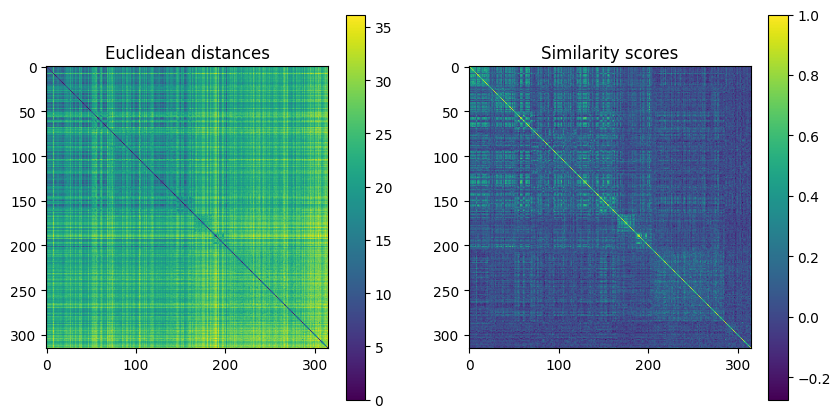

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

eu_matrix = euclidean_distances(embedding_matrix, embedding_matrix)
sim_matrix = cosine_similarity(embedding_matrix, embedding_matrix)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(eu_matrix)
plt.title('Euclidean distances')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(sim_matrix)
plt.colorbar()
plt.title('Similarity scores')


plt.show()


I notice that they kind of correspond, with the lighter regions on the euclidean distance matrix (meaning more distance between) being dark regions on the similarity matrix (meaning a lower similarity score). I also notice a linear line passing diagonally through both matrices which I think represents the relationship between the embeddings being close together and similar.


### Question 8
The following cell computes the correct acceptance rate as a function of the false acceptance rate while varying the threshold on the cosine similarity score for both males and females. What do you conclude ?

In [ ]:
from evaluation import Evaluation
from metrics import Metrics


eval = Evaluation(embeddings, labels, genders)
scores = eval.eval(model)
Metrics(scores).plot_roc()

AUC Question.
